# HW2: Classification with Logistic Regression

## Note: 
* You will need to finish **Code Task** for **Problem 1** before working on this notebook. 
* Your outputs, including tables and figures, don't need to be exactly the same as our sample outputs, but we do expect something as clear.

In [70]:
import os
import numpy as np
import pandas as pd

import sklearn.linear_model
import sklearn.metrics

In [71]:
# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', style='whitegrid', font_scale=1.25)

# Import starter code (should be completed by student in Problem 1)

In [72]:
from performance_metrics_for_binary_predictions import (
    calc_ACC, calc_TPR, calc_PPV, calc_TNR, calc_NPV)

# Import starter code (will work as distributed)

In [73]:
import threshold_selection

In [74]:
from confusion_matrix import calc_confusion_matrix_for_probas_and_threshold

# Provided function for computing mean binary cross entropy

Here, we provide a *completed* function you can use as is for Problem 1 report.

Later in Problem 2, you'll write your own version of this function without using sklearn.

Remember, we want the *base-2* cross entropy:

$$
BCE(y, p) = - y \log_2 p - (1-y) \log_2(1-p)
$$

In [75]:
def calc_mean_binary_cross_entropy_from_probas(ytrue_N, yproba1_N):
    ''' Compute mean binary cross entropy
    
    Args
    ----
    ytrue_N : 1D array, size (n_examples,) = (N,)
    yproba1_N : 1D array, size (n_examples,) = (N,)
    
    Returns
    -------
    mean_bce : float
        mean binary cross entropy across all N examples
    '''
    return sklearn.metrics.log_loss(ytrue_N, yproba1_N, labels=[0,1]) / np.log(2.0)

In [76]:
# Check that BCE loss is high if true class is 1 but probability is low
calc_mean_binary_cross_entropy_from_probas([1.], [0.01])

6.643856189774724

In [77]:
# Check that BCE loss is exactly 1 if true class is 1 but probability is 0.5
calc_mean_binary_cross_entropy_from_probas([1.], [0.5])

1.0

In [78]:
# Check that BCE loss is close to zero if true class is 1 but probability is 0.99
calc_mean_binary_cross_entropy_from_probas([1.], [0.99])

0.01449956969511509

# Problem 1: Binary Classifier for Cancer-Risk Screening

### Load the dataset

In [79]:
DATA_DIR = '/users/zoehsieh/Desktop/Comp135/hw2/'

In [80]:
# Load 3 feature version of x arrays
x_tr_M3 = np.loadtxt(os.path.join(DATA_DIR, 'x_train.csv'), delimiter=',', skiprows=1)
x_va_N3 = np.loadtxt(os.path.join(DATA_DIR, 'x_valid.csv'), delimiter=',', skiprows=1)
x_te_N3 = np.loadtxt(os.path.join(DATA_DIR, 'x_test.csv'), delimiter=',', skiprows=1)

In [81]:
N_shape = x_va_N3.shape
M_shape = x_tr_M3.shape

N = N_shape[0]
M = M_shape[0]

**TODO** : Load outcomes **y** arrays

In [82]:
# TODO : Load outcomes y arrays
# Hint: Follow the way we import x arrays.
y_tr_M = np.zeros(M)
y_va_N = np.zeros(N)
y_te_N = np.zeros(N) 

y_tr_M = np.loadtxt(os.path.join(DATA_DIR, 'y_train.csv'), delimiter=',', skiprows=1)
y_va_N = np.loadtxt(os.path.join(DATA_DIR, 'y_valid.csv'), delimiter=',', skiprows=1)
y_te_N = np.loadtxt(os.path.join(DATA_DIR, 'y_test.csv'), delimiter=',', skiprows=1)

In [83]:
# Load 2 feature version of x arrays
x_tr_M2 = x_tr_M3[:, :2].copy()
x_va_N2 = x_va_N3[:, :2].copy()
x_te_N2 = x_te_N3[:, :2].copy()


# Problem 1:
## Implementation Step 1A: Data Exploration

### Table 1 TODO
Provide a table summarizing some basic properties of the provided training set, validation set, and test set:

* Row 1 'total count': how many total examples are in each set, total?
* Row 2 'positive label count': how many examples have a positive label (means cancer)?
* Row 3 'fraction positive' : what fraction (between 0 and 1) of the examples have cancer?

Your result should be 3 by 3 containing 'total count', 'positive label count' and 'fraction positive' of training, valid and test sets. An example of the output looks like this:

|                                 |train    |valid     |test|
|:-|-:|-:|-:|
|num. total examples            |567.000  |123.000  |123.000
|num. positive examples         |56.000   |23.000   |23.000
|fraction of positive examples  |0.123    |0.123    |0.123

All results should **keep 3 digits**. 

##  Implementation Step 1B: The predict-0-always baseline

**TODO**: predict zero for all test data points

In [84]:
#TODO predict zero for all test data points

baseline_yhat_te_N = np.zeros(N)


In [85]:
print(calc_confusion_matrix_for_probas_and_threshold(y_te_N, baseline_yhat_te_N, 0.5))

Predicted    0  1
True             
0          155  0
1           25  0


**TODO** Use the printed information from the previous code cell to calculate the accuracy of baseline. 

Keep 3 digits in your PDF report for short Answer 1a.

In [86]:
baseline_acc = 155/180 # TODO: calculate the accuracy of baseline.
print("Baseline has accuracy:", baseline_acc)

Baseline has accuracy: 0.8611111111111112


#### Short Answer 1a  in Report
What accuracy (i.e. **baseline_acc** from above) does the "predict-0-always" classifier get on the test set (report to 3 decimal places)? (You should see a pretty good number). Does this mean we should use this classifier?

#### Short Answer 1b in Report

For the intended application (screening patients before biopsy), describe the possible mistakes the classifier can make in task-specific terms. What costs does each mistake entail (lost time? lost money? life-threatening harm?). How do you recommend evaluating a potential classifier to be mindful of these costs?

## Implementation Step 1C : Logistic Regression with F=2 dataset

**TODO**: Finish Part a, b, c, d in the next code block.

In [87]:
C_grid = np.logspace(-9, 6, 31)

# Store binary cross entropy (bce) for all C in C_grid;
# So we can compare and select the best C in the future steps.
tr_bce_list = list()
va_bce_list = list()
te_bce_list = list()

# Store the error rate: Fraction of examples that are mis-classified (using threshold=0.5)
# (We visualize it later, but don't use it in the report).
# Remember, we justified using BCE for training our classifier by saying
# it provides an *upper bound* on the error rate.
tr_err_list = list()
va_err_list = list()
te_err_list = list()

for C in C_grid:
    # TODO: Follow the instruction in HW2 and train the model lr_F2
    # Part a: Initialize your LogisticRegression classifier 
    # Part b: train the model with the 2-feature dataset
    lr_F2 = sklearn.linear_model.LogisticRegression(C=C, solver='lbfgs')
    
    # Part a
    
    lr_F2.fit(x_tr_M2, y_tr_M) # Part b
    
    yproba1_tr_M = lr_F2.predict_proba(x_tr_M2)[:,1] # The probability of predicting class 1 on the training set
    yproba1_va_N = lr_F2.predict_proba(x_va_N2)[:,1] # The probability of predicting class 1 on the validation set
    
    tr_err_list.append(sklearn.metrics.zero_one_loss(y_tr_M, yproba1_tr_M >= 0.5)) # Error rate for training set. 
    va_err_list.append(sklearn.metrics.zero_one_loss(y_va_N, yproba1_va_N >= 0.5)) # Error rate for validation set. 
    
    # TODO: using the calc_mean_binary_cross_entropy_from_probas() function from above:
    # Part c: calculate the binary cross entropy (bce) on the training set
    # Part d: calculate the binary cross entropy (bce) on the validation set
    my_tr_bce= calc_mean_binary_cross_entropy_from_probas(y_tr_M, yproba1_tr_M) 
    my_va_bce= calc_mean_binary_cross_entropy_from_probas(y_va_N, yproba1_va_N)
    
    # Save bce for future selection on Models.
    tr_bce_list.append(my_tr_bce) 
    va_bce_list.append(my_va_bce) 


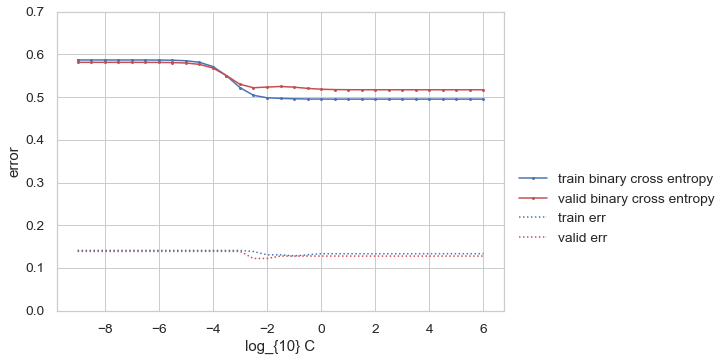

In [88]:
plt.plot(np.log10(C_grid), tr_bce_list, 'b.-', label='train binary cross entropy')
plt.plot(np.log10(C_grid), va_bce_list, 'r.-', label='valid binary cross entropy')

plt.plot(np.log10(C_grid), tr_err_list, 'b:', label='train err')
plt.plot(np.log10(C_grid), va_err_list, 'r:', label='valid err')

plt.ylabel('error')
plt.xlabel("log_{10} C");
plt.legend(bbox_to_anchor=(1.5, 0.5)) # make legend outside plot
plt.ylim([0, 0.7]);

### Check Point:

If your code is correct, you should produce exactly the same figure when you run the cell above as:

**"Checkpoint1C.jpg"** in the same folder as your starter code.
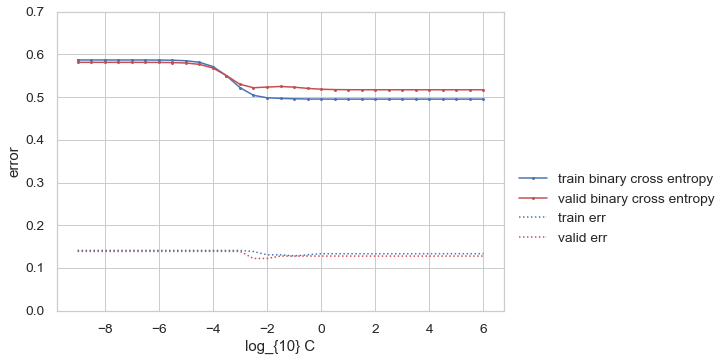

In [89]:
print("Searched over these C values:")
print(C_grid)

Searched over these C values:
[1.00000000e-09 3.16227766e-09 1.00000000e-08 3.16227766e-08
 1.00000000e-07 3.16227766e-07 1.00000000e-06 3.16227766e-06
 1.00000000e-05 3.16227766e-05 1.00000000e-04 3.16227766e-04
 1.00000000e-03 3.16227766e-03 1.00000000e-02 3.16227766e-02
 1.00000000e-01 3.16227766e-01 1.00000000e+00 3.16227766e+00
 1.00000000e+01 3.16227766e+01 1.00000000e+02 3.16227766e+02
 1.00000000e+03 3.16227766e+03 1.00000000e+04 3.16227766e+04
 1.00000000e+05 3.16227766e+05 1.00000000e+06]


**TODO** Find the best C with the samllest cross entropy loss on the validation set.

In [90]:
# TODO Find the best C with the samllest cross entropy loss on the validation set
index = np.where(va_bce_list == np.amin(va_bce_list))

best_C__lrF2= C_grid[index]

print("Best C value for F2 model:")
print(best_C__lrF2)

Best C value for F2 model:
[1000000.]


**TODO** Initialize and train using the Best C from the previous experiment.

In [91]:
# TODO Initialize and train using the Best C from the previous experiment.
# Part a: Initialize the model using the Best C (i.e. best_C__lrF2) from the previous experiment 
# Part b: retrieve the best model by training on the training set again.

best_lrF2 = sklearn.linear_model.LogisticRegression(C = 1000000, solver='lbfgs')
best_lrF2.fit(x_tr_M2, y_tr_M)

LogisticRegression(C=1000000)

In [92]:
# Output the prediction of your best model for 2-feature data on the training, valid, and test set. 
# Return the posibility of predicting true
# We'll use them for the ROC curve
bestlrF2_yproba1_tr_M = best_lrF2.predict_proba(x_tr_M2)[:,1]
bestlrF2_yproba1_va_N = best_lrF2.predict_proba(x_va_N2)[:,1]
bestlrF2_yproba1_te_N = best_lrF2.predict_proba(x_te_N2)[:,1]

## Implementation Step 1D : Logistic Regression with F=3 dataset
**TODO**: 
* Repeat Step 1C for 3-feature Dataset to find the best C. 

Best C value for F3 model:
[1000000.]


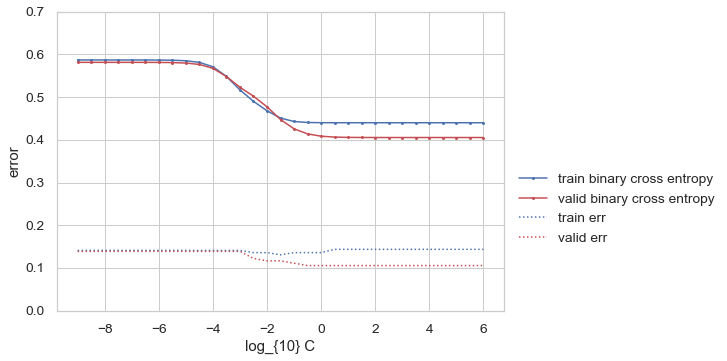

In [93]:
C3_grid = np.logspace(-9, 6, 31)

# Store binary cross entropy (bce) for all C in C_grid;
# So we can compare and select the best C in the future steps.
tr3_bce_list = list()
va3_bce_list = list()
te3_bce_list = list()

# Store the error rate: Fraction of examples that are mis-classified (using threshold=0.5)
# (We visualize it later, but don't use it in the report).
# Remember, we justified using BCE for training our classifier by saying
# it provides an *upper bound* on the error rate.
tr3_err_list = list()
va3_err_list = list()
te3_err_list = list()

for C in C3_grid:
    # TODO: Follow the instruction in HW2 and train the model lr_F2
    # Part a: Initialize your LogisticRegression classifier 
    # Part b: train the model with the 2-feature dataset
    lr_F3 = sklearn.linear_model.LogisticRegression(C=C, solver='lbfgs')
    
    # Part a
    lr_F3.fit(x_tr_M3, y_tr_M) # Part b
    
    yproba1_tr_M = lr_F3.predict_proba(x_tr_M3)[:,1] # The probability of predicting class 1 on the training set
    yproba1_va_N = lr_F3.predict_proba(x_va_N3)[:,1] # The probability of predicting class 1 on the validation set
    
    tr3_err_list.append(sklearn.metrics.zero_one_loss(y_tr_M, yproba1_tr_M >= 0.5)) # Error rate for training set. 
    va3_err_list.append(sklearn.metrics.zero_one_loss(y_va_N, yproba1_va_N >= 0.5)) # Error rate for validation set. 
    
    # TODO: using the calc_mean_binary_cross_entropy_from_probas() function from above:
    # Part c: calculate the binary cross entropy (bce) on the training set
    # Part d: calculate the binary cross entropy (bce) on the validation set
    my3_tr_bce= calc_mean_binary_cross_entropy_from_probas(y_tr_M, yproba1_tr_M) 
    my3_va_bce= calc_mean_binary_cross_entropy_from_probas(y_va_N, yproba1_va_N)
    
    # Save bce for future selection on Models.
    tr3_bce_list.append(my3_tr_bce) 
    va3_bce_list.append(my3_va_bce) 
    
    
    
index = np.where(va3_bce_list == np.amin(va3_bce_list))

best_C__lrF3= C3_grid[index]

print("Best C value for F3 model:")
print(best_C__lrF3)
plt.plot(np.log10(C3_grid), tr3_bce_list, 'b.-', label='train binary cross entropy')
plt.plot(np.log10(C3_grid), va3_bce_list, 'r.-', label='valid binary cross entropy')

plt.plot(np.log10(C3_grid), tr3_err_list, 'b:', label='train err')
plt.plot(np.log10(C3_grid), va3_err_list, 'r:', label='valid err')

plt.ylabel('error')
plt.xlabel("log_{10} C");
plt.legend(bbox_to_anchor=(1.5, 0.5)) # make legend outside plot
plt.ylim([0, 0.7]);

**TODO**:
* Select the best C and retrieve the best model. You should name the model as "**best_lrF3**".

In [94]:
best_lrF3 = sklearn.linear_model.LogisticRegression(C= 1000000, solver='lbfgs')
best_lrF3.fit(x_tr_M3, y_tr_M)

LogisticRegression(C=1000000)

**TODO**:
* Return the posibility of predicting true on training, validation and test set.

In [95]:
# TODO: Return the posibility of predicting true on training, validation and test set.
# Part a Return the posibility of predicting true on training set.
# Part b Return the posibility of predicting true on validation set.
# Part c Return the posibility of predicting true on test set.

# Hint: follow what's done in the last code block of Step 1C.

bestlrF3_yproba1_tr_M = best_lrF3.predict_proba(x_tr_M3)[:,1]
bestlrF3_yproba1_va_N = best_lrF3.predict_proba(x_va_N3)[:,1]
bestlrF3_yproba1_te_N = best_lrF3.predict_proba(x_te_N3)[:,1]

### Figure 1 for the report: Comparing models using ROC analysis
**TODO**:
Follow the instruction to produce the figure for your report

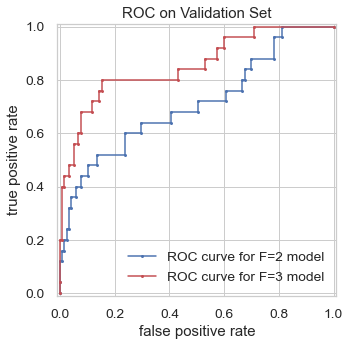

In [96]:
# Follow the instruction of HW2 and produce Figure 1 for your report:
plt.subplots(nrows=1, ncols=1, figsize=(5,5));

#TODO Using your data and predictions of the Validation set, Produce the ROC Curve utilizing  
#     `sklearn.metrics.roc_curve' within plt defined above.
#     To Start with, Google and Read the official Document and examples of 'sklearn.metrics.roc_curve'. 

#     Read the instruction of HW2 carefully about the requirements of your plot (line type, line color, etc.)

#sklearn.metric.roc_curve(bestlrF2_yproba1_va_N, bestlrF3_yproba1_va_N)

fpr2, tpr2, thresholds = sklearn.metrics.roc_curve(y_va_N, bestlrF2_yproba1_va_N)
fpr3, tpr3, thresholds = sklearn.metrics.roc_curve(y_va_N, bestlrF3_yproba1_va_N)

plt.plot(fpr2, tpr2, 'b.-', label='ROC curve for F=2 model')
plt.plot(fpr3, tpr3, 'r.-', label='ROC curve for F=3 model')

plt.title("ROC on Validation Set");
plt.xlabel('false positive rate');
plt.ylabel('true positive rate');
plt.legend(loc='lower right');
B = 0.01
plt.xlim([0 - B, 1 + B]);
plt.ylim([0 - B, 1 + B]);

#### Short Answer 1c in Report

Compare the two models in terms of their ROC curves from Figure 1. Does one dominate the other in terms of overall performance, or are there areas where one model “wins” and others where the other model does? Which model do recommend for the task at hand?

In [122]:
import numpy as np

from performance_metrics_for_binary_predictions import (
    calc_ACC, calc_TPR, calc_TNR, calc_PPV, calc_NPV)

def compute_perf_metrics_across_thresholds(ytrue_N, yproba1_N, thresh_grid=None):
    ''' Compute common binary classifier performance metrics across many thresholds
    
    If no array of thresholds is provided, will use all 'unique' values
    in the yproba1_N array to define all possible thresholds with different performance.
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yproba1_N : 1D array of floats
        Each entry represents a probability (between 0 and 1) that correct label is positive (1)
        One entry per example in current dataset
    Returns
    -------
    thresh_grid : 1D array of floats
        One entry for each possible threshold
    perf_dict : dict, with key, value pairs:
        * 'acc' : 1D array of accuracy values (one per threshold)
        * 'ppv' : 1D array of positive predictive values (one per threshold)
        * 'npv' : 1D array of negative predictive values (one per threshold)
        * 'tpr' : 1D array of true positive rates (one per threshold)
        * 'tnr' : 1D array of true negative rates (one per threshold)
    '''
    if thresh_grid is None:
        # Build default grid from 0.0 up to 1.000001 with 5 values
        default_thr_grid = np.linspace(0, 1.000001, 5)
        # Could threshold at each possible unique value of yproba
        unique_thr_grid = np.unique(yproba1_N)
        # Combine unique values with default ones to get reasonable coverage
        thresh_grid = np.sort(np.hstack([default_thr_grid, unique_thr_grid]))


    tpr_grid = np.zeros_like(thresh_grid)
    tnr_grid = np.zeros_like(thresh_grid)
    ppv_grid = np.zeros_like(thresh_grid)
    npv_grid = np.zeros_like(thresh_grid)
    acc_grid = np.zeros_like(thresh_grid)
    for tt, thresh in enumerate(thresh_grid):
        # Apply specific threshold to convert probas into hard binary values (0 or 1)
        yhat_N = np.asarray(yproba1_N >= thresh, dtype=np.int32)

        # Then count number of true positives, true negatives, etc.
        # Then compute metrics like accuracy and true positive rate
        acc_grid[tt] = calc_ACC(ytrue_N, yhat_N)
        tpr_grid[tt] = calc_TPR(ytrue_N, yhat_N)
        tnr_grid[tt] = calc_TNR(ytrue_N, yhat_N)
        ppv_grid[tt] = calc_PPV(ytrue_N, yhat_N)
        npv_grid[tt] = calc_NPV(ytrue_N, yhat_N)

    return thresh_grid, dict(
        acc=acc_grid,
        tpr=tpr_grid,
        tnr=tnr_grid,
        ppv=ppv_grid,
        npv=npv_grid)

## Implementation Step 1E & F: Selecting a decision threshold

### Figure 2 for Report

**TODO**: Follow the instructions for **Figure2 Column 1,2,3** and produce a plot such that:  
Each column should correspond to one of the following models:

* F=3 Logistic Regression (from 1D above), using threshold 0.5
* F=3 Logistic Regression (from 1D above), using threshold from 1E above
* F=3 Logistic Regression (from 1D above), using threshold from 1F above

Each row should report some performance of the model on the **test** set:
* Title: **Threshold** **(with 4 digits)** + which case (i.e **default**, **PPV >= 0.98** or **TPR>=0.98**)
* Top Row: **Confusion Matrix** on the test set. **(with Integers)**
* Bottom Row: at least **TPR** and **PPV** on the test set. **(with 3 digits)**

**Once you finish all three Columns of figure 2, please combine them into one figure and include it in your PDF report.**

### Figure2 Column1: Use F=3 LR model, Use default 0.5 threshold
#### TODO: 
* Produce the confusion matrix 
* Return at least TPR and PPV on the test set

A sample output looks like this: 

<center>Chosen thr = 0.5000 (Default)</center>

||**Predicted**|**0**|**1**|
|:-:|:-|-:|-:|
|**True Result**| | | |
|**0**     |     |100   |5|
|**1**     |      |10  |10| 

|**Metric**|**Score**|
|-:|-:|
|TPR  |0.300|
|PPV  |0.719|
|TNR  |0.234|
|NPV  |0.900|

### Figure2 Column2: Use F=3 LR model, Pick threshold to maximize TPR s.t. PPV >= 0.98

In [123]:

print(y_va_N)
print(bestlrF3_yproba1_va_N)
thresh_grid, va_perf_grid = threshold_selection.compute_perf_metrics_across_thresholds(
    y_va_N, bestlrF3_yproba1_va_N)
print(va_perf_grid)
va_tpr = va_perf_grid['tpr']
va_ppv = va_perf_grid['ppv']

print(va_tpr)

feasible_mask = va_ppv >= 0.98 # Select all indexes in the array va_ppv that has ppv >= 0.98

# Pull out all feasible thresholds as well as their tpr and ppv values.
thr_feasible = thresh_grid[feasible_mask]
tpr_feasible = va_tpr[feasible_mask]
ppv_feasible = va_ppv[feasible_mask]


#print(va_perf_grid)
#print(thresh_grid)
print(va_tpr)
print(thr_feasible)
#print(ppv_feasible)



#max_tpr = np.amax(tpr_feasible)
#print(max_tpr)

[1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0.2601874  0.19215835 0.05791719 0.0357646  0.18270629 0.28218284
 0.00442683 0.03680999 0.0295794  0.02302934 0.01581312 0.30443936
 0.00830289 0.40484106 0.04990807 0.42803637 0.11686387 0.11263188
 0.67314743 0.06429068 0.14307525 0.02603244 0.14625887 0.23843721
 0.32406559 0.43552515 0.00683388 0.11005485 0.01921593 0.06197658
 0.03954264 0.24828618 0.16508712 0.12182524 0.36207326 0.88828349
 0.26025926 0.38647039 0.35323253 0.0950866  0.09

**TODO**: Finish the code block to get the best threshold.

In [121]:
# Find threshold that makes TPR as large as possible, while satisfying PPV >= 0.98
# TODO Find the index (i.e. ii) of the largest TPR while PPV >= 0.98
#ii = # Find the index of the largest TPR while PPV >= 0.98
best_thr = thr_feasible[ii] # Get the threshold

print("Chosen thr = %.4f" % best_thr)

SyntaxError: invalid syntax (<ipython-input-121-209a60f8a22c>, line 3)

**TODO**: Using the chosen **best_thr** above
* Produce the confusion matrix 
* Return at least TPR and PPV on the test set

A sample output looks like this:

<center>Chosen thr = 0.5678 (PPV >= 0.98)</center>

||**Predicted**|**0**|**1**|
|:-:|:-|-:|-:|
|**True Result**| | | |
|**0**     |     |100   |5|
|**1**     |      |10  |10| 

|**Metric**|**Score**|
|-:|-:|
|TPR  |0.300|
|PPV  |0.719|
|TNR  |0.234|
|NPV  |0.900|

### Figure2 Column3: Use F=3 LR model, Pick threshold to maximize PPV s.t. TPR >= 0.98
#### TODO: 
Using a similar logistic from **Figure2 Column2**,
* Choose threshold that makes TPR as large as possible, while satisfying PPV >= 0.98
* Produce the confusion matrix using the chosen threshold
* Return at least TPR and PPV on the test set using the chosen threshold

A sample output looks like this:

<center>Chosen thr = 0.1234 (TPR >= 0.98)</center>

||**Predicted**|**0**|**1**|
|:-:|:-|-:|-:|
|**True Result**| | | |
|**0**     |     |100   |5|
|**1**     |      |10  |10| 

|**Metric**|**Score**|
|-:|-:|
|TPR  |0.300|
|PPV  |0.719|
|TNR  |0.234|
|NPV  |0.900|

Once you finish all three parts of figure 2, plase **combine all 3 column** into **one figure** and include it in your PDF report. Remember to **add titles** (Threshold + which case) to each column.

#### Short Answer 1d in Report

Compare the confusion matrices in Figure 1. Which model and thresholding strategy best meets our preferences from 1b: avoid life-threatening mistakes at all costs, while also eliminating unnecessary biopsies?

#### Short Answer 1e in Report

By carefully reading the confusion matrices from Figure 2, estimate how many subjects in the test set are saved from unnecessary biopsies using your selected thresholding strategy. What fraction of current biopsies might be avoided if this classifier was adopted by the hospital?